## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
eps = 0.32
kappa = 1.7
delta = 0.33
Amax = 10
num_A = 20

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array([[0.0,0.0,0.0]])
    tau = np.linspace(0, 2 * np.pi, N)
    Arange = np.linspace(-Amax, Amax, num_A)
    # Define boundary of ellipse
    #x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
    #                eps * kappa * np.sin(tau), Arange]).T
    
    R_ellipse = np.outer(1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)),
                             np.ones(num_A)
                             )
    Z_ellipse = np.outer(eps * kappa * np.sin(tau),
                             np.ones(num_A)
                             )
    A_ellipse = np.outer(np.ones(N), Arange)
    x_ellipse = np.transpose(np.asarray([R_ellipse, Z_ellipse, A_ellipse]), [1, 2, 0])
    x_ellipse = x_ellipse.reshape(N * num_A, 3)

    print(x_ellipse.shape)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse_A(eps, kappa, delta, Amax=Amax) 

x, u = gen_traindata(200)

n_test = 100

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=2048,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term

(4000, 3)


In [2]:
data.train_x_bc.shape

(4000, 3)

Text(0.5, 0, '$u(r,z=0)$')

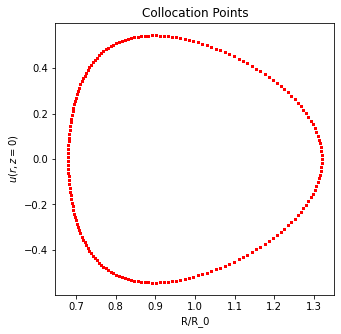

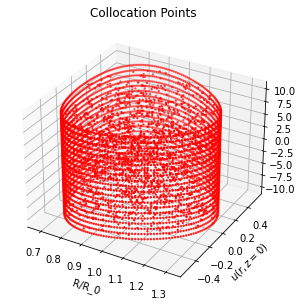

In [3]:
# Plot collocation points for visual check
# %matplotlib

fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(data.train_x[:,0], data.train_x[:,1], data.train_x[:,2], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [4]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.124630 s



/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 5.709213 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.82e+00, 1.61e-02]    [4.05e+00, 1.61e-02]    []  
10        [3.81e+00, 4.90e-02]    [3.13e+00, 4.90e-02]    []  
20        [3.20e+00, 4.19e-02]    [2.55e+00, 4.19e-02]    []  
30        [2.95e+00, 5.33e-02]    [2.29e+00, 5.33e-02]    []  
40        [1.75e+00, 1.83e-01]    [1.41e+00, 1.83e-01]    []  
50        [1.39e+00, 5.87e-02]    [1.14e+00, 5.87e-02]    []  
60        [4.84e-01, 8.27e-02]    [3.23e-01, 8.27e-02]    []  
70        [3.89e-01, 3.74e-02]    [2.73e-01, 3.74e-02]    []  
80        [2.36e-01, 3.05e-02]    [1.93e-01, 3.05e-02]    []  
90        [1.60e-01, 3.10e-02]    [1.43e-01, 3.10e-02]    []  
100       [1.07e-01, 3.18e-02]    [8.73e-02, 3.18e-02]    []  

Best model at step 100:
  train loss: 1.39e-01
  test loss: 1.19e-01
  test metric: []

'train' took 20.061873 s

Saving loss history to ./cefron/ITER/runs/network_

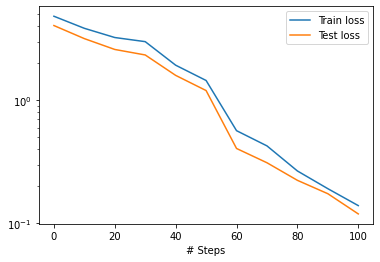

In [5]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

Compiling model...
'compile' took 4.150577 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.07e-01, 3.18e+00]    [8.73e-02, 3.18e+00]    []  
110       [7.81e-01, 7.90e-01]    [7.81e-01, 7.90e-01]        
120       [4.35e-01, 2.99e-01]    [4.35e-01, 2.99e-01]        
130       [3.13e-01, 1.10e-01]    [3.13e-01, 1.10e-01]        
140       [2.43e-01, 8.70e-02]    [2.43e-01, 8.70e-02]        
150       [1.74e-01, 5.99e-02]    [1.74e-01, 5.99e-02]        
160       [1.16e-01, 4.71e-02]    [1.16e-01, 4.71e-02]        
170       [1.01e-01, 2.64e-02]    [1.01e-01, 2.64e-02]        
180       [6.59e-02, 2.15e-02]    [6.59e-02, 2.15e-02]        
190       [4.44e-02, 1.77e-02]    [4.44e-02, 1.77e-02]        
200       [3.09e-02, 1.50e-02]    [3.09e-02, 1.50e-02]        
210       [2.22e-02, 9.21e-03]    [2.22e-02, 9.21e-03]        
220       [1.87e-02, 3.94e-03]    [1.87e-02, 3.94e-03]        
230       [1.64e-02, 3.46e-03]    [1.64e-02, 3

1370      [2.10e-04, 3.34e-04]    [2.10e-04, 3.34e-04]        
1380      [2.09e-04, 3.34e-04]    [2.09e-04, 3.34e-04]        
1390      [2.09e-04, 3.28e-04]    [2.09e-04, 3.28e-04]        
1400      [2.08e-04, 3.26e-04]    [2.08e-04, 3.26e-04]        
1410      [2.07e-04, 3.23e-04]    [2.07e-04, 3.23e-04]        
1420      [2.02e-04, 3.23e-04]    [2.02e-04, 3.23e-04]        
1430      [2.00e-04, 3.21e-04]    [2.00e-04, 3.21e-04]        
1440      [1.98e-04, 3.19e-04]    [1.98e-04, 3.19e-04]        
1450      [1.97e-04, 3.19e-04]    [1.97e-04, 3.19e-04]        
1460      [1.96e-04, 3.15e-04]    [1.96e-04, 3.15e-04]        
1470      [1.94e-04, 3.15e-04]    [1.94e-04, 3.15e-04]        
1480      [1.93e-04, 3.13e-04]    [1.93e-04, 3.13e-04]        
1490      [1.91e-04, 3.07e-04]    [1.91e-04, 3.07e-04]        
1500      [1.90e-04, 2.96e-04]    [1.90e-04, 2.96e-04]        
1510      [1.89e-04, 2.88e-04]    [1.89e-04, 2.88e-04]        
1520      [1.93e-04, 2.77e-04]    [1.93e-04, 2.77e-04] 

2680      [7.40e-05, 4.42e-05]    [7.40e-05, 4.42e-05]        
2690      [7.33e-05, 4.44e-05]    [7.33e-05, 4.44e-05]        
2700      [7.22e-05, 4.43e-05]    [7.22e-05, 4.43e-05]        
2710      [7.23e-05, 4.24e-05]    [7.23e-05, 4.24e-05]        
2720      [7.14e-05, 4.07e-05]    [7.14e-05, 4.07e-05]        
2730      [7.08e-05, 4.01e-05]    [7.08e-05, 4.01e-05]        
2740      [7.01e-05, 3.99e-05]    [7.01e-05, 3.99e-05]        
2750      [6.92e-05, 4.05e-05]    [6.92e-05, 4.05e-05]        
2760      [6.87e-05, 4.08e-05]    [6.87e-05, 4.08e-05]        
2770      [6.82e-05, 4.10e-05]    [6.82e-05, 4.10e-05]        
2780      [6.72e-05, 4.16e-05]    [6.72e-05, 4.16e-05]        
2790      [6.59e-05, 4.22e-05]    [6.59e-05, 4.22e-05]        
2800      [6.52e-05, 4.21e-05]    [6.52e-05, 4.21e-05]        
2810      [6.45e-05, 4.17e-05]    [6.45e-05, 4.17e-05]        
2820      [6.43e-05, 4.17e-05]    [6.43e-05, 4.17e-05]        
2830      [6.41e-05, 4.16e-05]    [6.41e-05, 4.16e-05] 

3990      [2.72e-05, 2.05e-05]    [2.72e-05, 2.05e-05]        
4000      [2.73e-05, 2.00e-05]    [2.73e-05, 2.00e-05]        
4010      [2.66e-05, 2.00e-05]    [2.66e-05, 2.00e-05]        
4020      [2.57e-05, 2.01e-05]    [2.57e-05, 2.01e-05]        
4030      [2.54e-05, 1.99e-05]    [2.54e-05, 1.99e-05]        
4040      [2.55e-05, 1.95e-05]    [2.55e-05, 1.95e-05]        
4050      [2.53e-05, 1.92e-05]    [2.53e-05, 1.92e-05]        
4060      [2.50e-05, 1.90e-05]    [2.50e-05, 1.90e-05]        
4070      [2.50e-05, 1.86e-05]    [2.50e-05, 1.86e-05]        
4080      [2.46e-05, 1.85e-05]    [2.46e-05, 1.85e-05]        
4090      [2.42e-05, 1.85e-05]    [2.42e-05, 1.85e-05]        
4100      [2.40e-05, 1.84e-05]    [2.40e-05, 1.84e-05]        
4110      [2.38e-05, 1.83e-05]    [2.38e-05, 1.83e-05]        
4120      [2.37e-05, 1.83e-05]    [2.37e-05, 1.83e-05]        
4130      [2.39e-05, 1.79e-05]    [2.39e-05, 1.79e-05]        
4140      [2.38e-05, 1.79e-05]    [2.38e-05, 1.79e-05] 

5300      [1.30e-05, 8.33e-06]    [1.30e-05, 8.33e-06]        
5310      [1.31e-05, 7.93e-06]    [1.31e-05, 7.93e-06]        
5320      [1.29e-05, 7.87e-06]    [1.29e-05, 7.87e-06]        
5330      [1.28e-05, 7.86e-06]    [1.28e-05, 7.86e-06]        
5340      [1.26e-05, 7.89e-06]    [1.26e-05, 7.89e-06]        
5350      [1.25e-05, 7.90e-06]    [1.25e-05, 7.90e-06]        
5360      [1.23e-05, 7.99e-06]    [1.23e-05, 7.99e-06]        
5370      [1.21e-05, 8.05e-06]    [1.21e-05, 8.05e-06]        
5380      [1.20e-05, 8.06e-06]    [1.20e-05, 8.06e-06]        
5390      [1.19e-05, 8.08e-06]    [1.19e-05, 8.08e-06]        
5400      [1.19e-05, 7.94e-06]    [1.19e-05, 7.94e-06]        
5410      [1.17e-05, 7.97e-06]    [1.17e-05, 7.97e-06]        
5420      [1.17e-05, 7.98e-06]    [1.17e-05, 7.98e-06]        
5430      [1.17e-05, 7.88e-06]    [1.17e-05, 7.88e-06]        
5440      [1.17e-05, 7.81e-06]    [1.17e-05, 7.81e-06]        
5450      [1.16e-05, 7.88e-06]    [1.16e-05, 7.88e-06] 

6610      [7.36e-06, 3.60e-06]    [7.36e-06, 3.60e-06]        
6620      [7.32e-06, 3.61e-06]    [7.32e-06, 3.61e-06]        
6630      [7.31e-06, 3.57e-06]    [7.31e-06, 3.57e-06]        
6640      [7.26e-06, 3.58e-06]    [7.26e-06, 3.58e-06]        
6650      [7.20e-06, 3.56e-06]    [7.20e-06, 3.56e-06]        
6660      [7.20e-06, 3.47e-06]    [7.20e-06, 3.47e-06]        
6670      [7.20e-06, 3.43e-06]    [7.20e-06, 3.43e-06]        
6680      [7.20e-06, 3.39e-06]    [7.20e-06, 3.39e-06]        
6690      [7.15e-06, 3.35e-06]    [7.15e-06, 3.35e-06]        
6700      [7.12e-06, 3.28e-06]    [7.12e-06, 3.28e-06]        
6710      [7.05e-06, 3.28e-06]    [7.05e-06, 3.28e-06]        
6720      [6.95e-06, 3.30e-06]    [6.95e-06, 3.30e-06]        
6730      [6.83e-06, 3.32e-06]    [6.83e-06, 3.32e-06]        
6740      [6.80e-06, 3.30e-06]    [6.80e-06, 3.30e-06]        
6750      [6.82e-06, 3.22e-06]    [6.82e-06, 3.22e-06]        
6760      [6.82e-06, 3.18e-06]    [6.82e-06, 3.18e-06] 

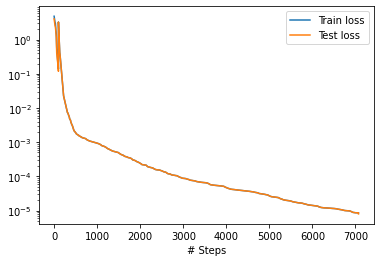

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every 2= 10)
dde.saveplot(loss_history, train_state, issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [7]:
# Evaluation
from utils.utils import evaluate_parametric, relative_error_plot
ITER = GS_Linear(eps=eps, kappa=kappa, delta=delta)
xfull,yfull,A,psi_pred_full,psi_true_full,error=evaluate_parametric(
    ITER, model, Amax, num_A=num_A,
)
# X_test = spatial_domain.random_points(300)


(52020, 3)
(4000, 3)


[[-0.15042203 -0.14161007 -0.13349449 ... -0.13349449 -0.14161007
  -0.15042203]
 [-0.13664912 -0.12771796 -0.1195095  ... -0.1195095  -0.12771796
  -0.13664912]
 [-0.12397588 -0.11494159 -0.10665568 ... -0.10665568 -0.11494159
  -0.12397588]
 ...
 [ 0.5712613   0.54054968  0.50987409 ...  0.50987409  0.54054968
   0.5712613 ]
 [ 0.63058273  0.59746605  0.56447227 ...  0.56447227  0.59746605
   0.63058273]
 [ 0.69400602  0.65839635  0.62300047 ...  0.62300047  0.65839635
   0.69400602]] [[ 0.20141709  0.19128853  0.18190992 ...  0.18190992  0.19128853
   0.20141709]
 [ 0.18534725  0.17484266  0.1651225  ...  0.1651225   0.17484266
   0.18534725]
 [ 0.17049422  0.15962186  0.14956813 ...  0.14956813  0.15962186
   0.17049422]
 ...
 [-0.1974001  -0.19156351 -0.18486372 ... -0.18486372 -0.19156351
  -0.1974001 ]
 [-0.23248716 -0.22504229 -0.21679078 ... -0.21679078 -0.22504229
  -0.23248716]
 [-0.2705663  -0.26144049 -0.25156797 ... -0.25156797 -0.26144049
  -0.2705663 ]] 20


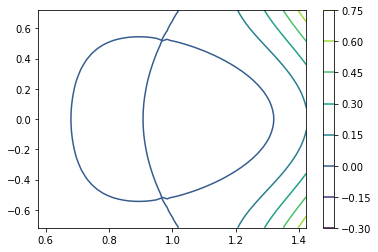

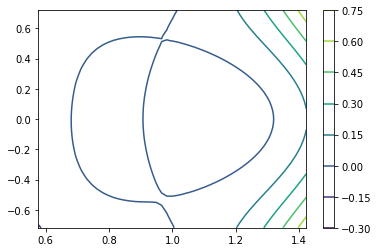

In [8]:
print(psi_true_full[:, :, 0], psi_true_full[:, :, -1], xfull.shape[2])
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_full[:, :, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_full[:, :, 0])
plt.colorbar()

0
2
4
6
8
10
12
14
16
18


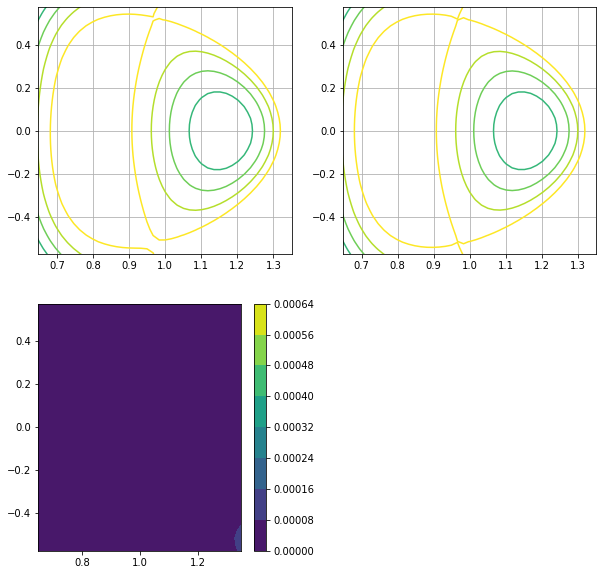

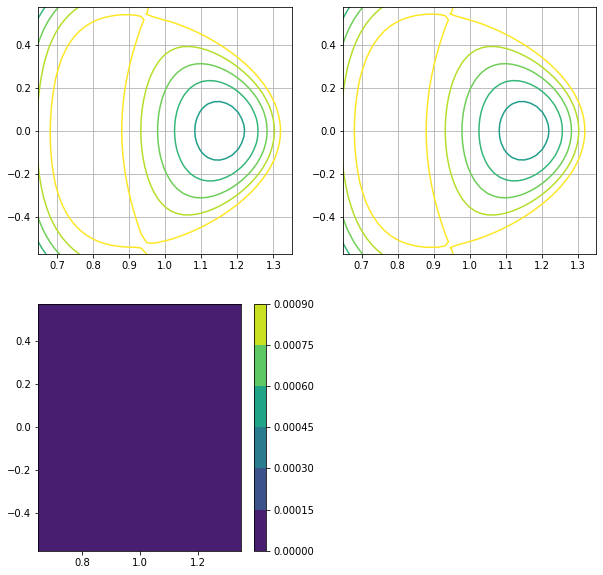

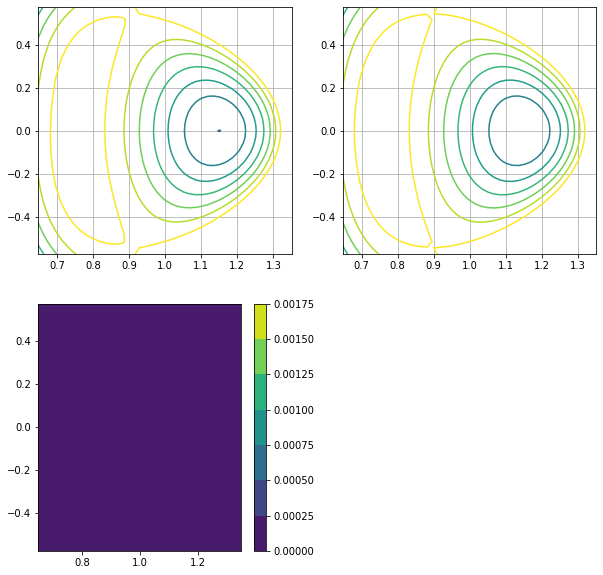

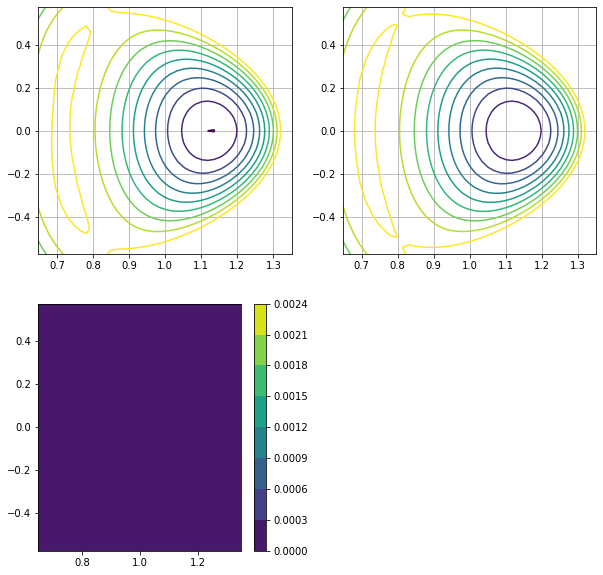

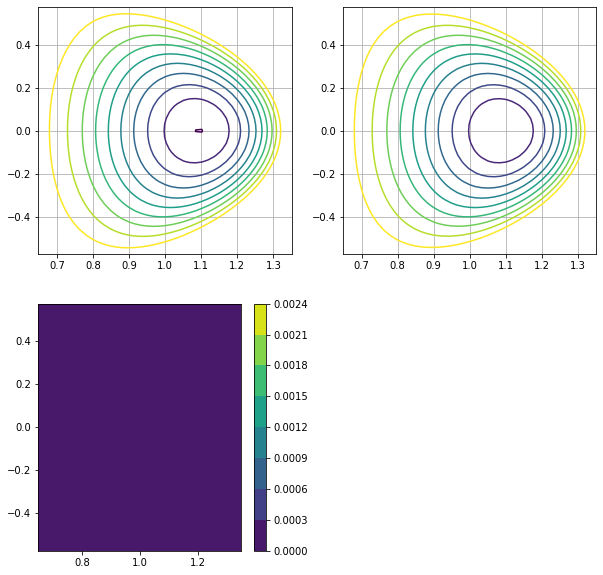

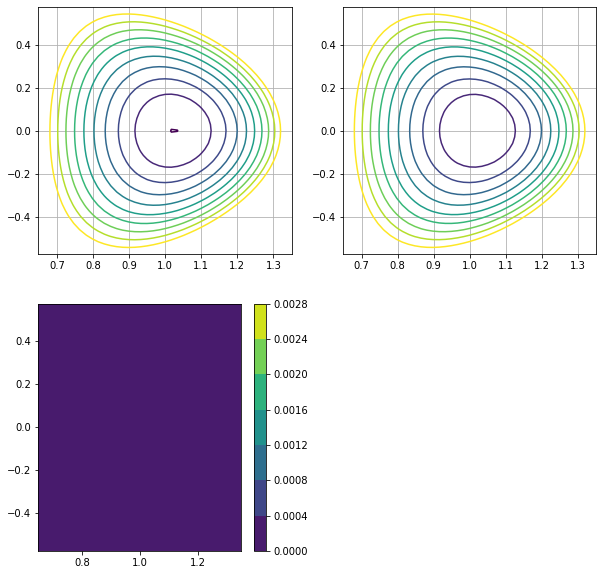

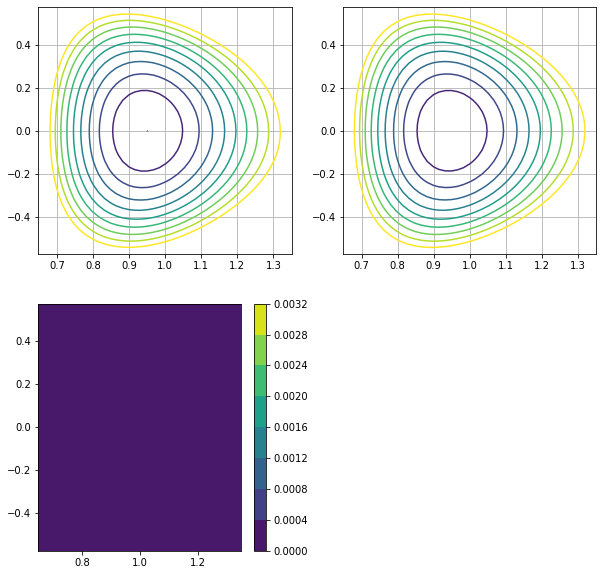

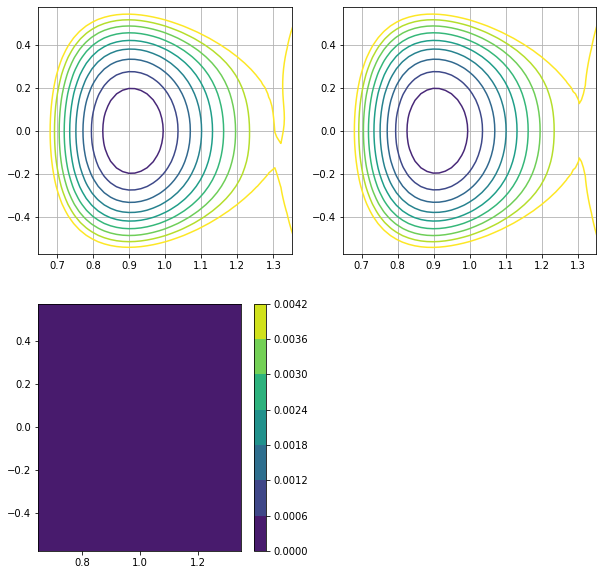

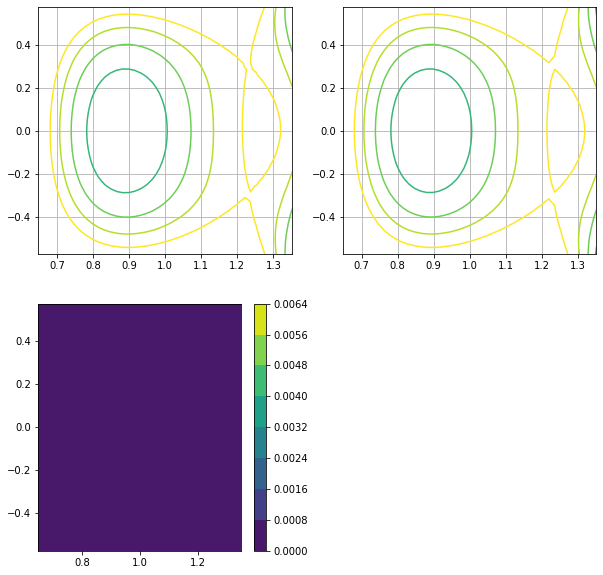

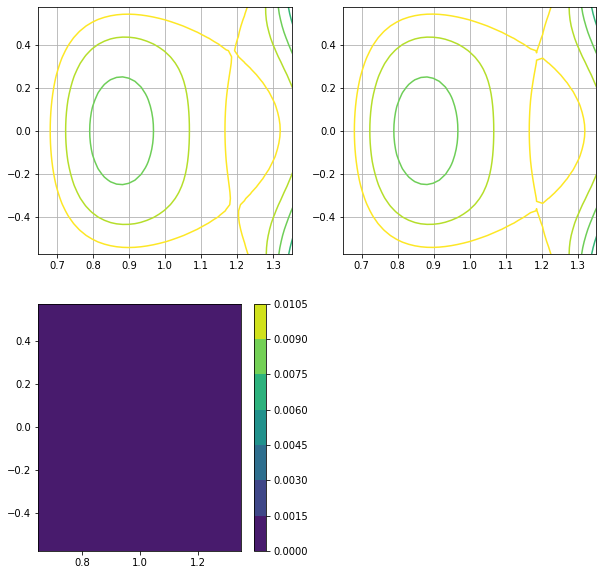

In [9]:
# Plotting Setup
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom

for i in range(0, xfull.shape[2], 2):
    print(i)
    plt.figure(i + 1, figsize=(10,10))

    levels = np.linspace(min(psi_true_full[:, :, i].reshape(-1)),0,10)
#     print(levels)
    
    plt.subplot(2, 2, 1)
    # Plot 1 - PINN Solution
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_pred_full[:, :, i],levels=levels)
    # ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
    #plt.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
    #ax1.set_title('PINN Solution')
    #ax1.set_xlabel(r'$R/R_{0}$')
    #ax1.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 2 - Analytic Solution
    plt.subplot(2, 2, 2)
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_true_full[:, :, i],levels=levels)
    #plt.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax2.set_xlabel(r'$R/R_{0}$')
    #ax2.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 4 - Relative Error
    plt.subplot(2, 2, 3)
    cp = plt.contourf(xfull[:, :, i], yfull[:, :, i], error[:, :, i])  #,levels=levels)
    #fig.colorbar(cp,ax=ax3).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax3.set_xlabel(r'$R/R_{0}$')
    #ax3.set_ylabel(r'$Z/R_{0}$')
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)
    plt.colorbar()

    fig.tight_layout()
    #plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS_A' + str(A[0, 0, i]) + ' .jpg')

